In [10]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  1.0.0
Torchvision Version:  0.2.1


In [101]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "./data/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 24

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True


In [105]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm_notebook(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm_notebook(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()
        if (epoch % 5 == 0):
            plt.plot(val_acc_history)
            plt.plot

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [26]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [27]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [75]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomRotation(180),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomRotation(180),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomRotation(180),
        transforms.CenterCrop(input_size),           
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

image_datasets2 = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['val','test']}
# Create training and validation dataloaders
dataloaders_dict2 = {x: torch.utils.data.DataLoader(image_datasets2[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['val','test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Initializing Datasets and Dataloaders...


In [106]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


Params to learn:
	 fc.weight
	 fc.bias


Epoch 0/49
----------


train Loss: 0.9774 Acc: 0.6972


val Loss: 0.4613 Acc: 0.8663

Epoch 1/49
----------


train Loss: 0.9948 Acc: 0.6870


val Loss: 0.4521 Acc: 0.8609

Epoch 2/49
----------


train Loss: 0.9352 Acc: 0.7106


val Loss: 0.4395 Acc: 0.8650

Epoch 3/49
----------


train Loss: 0.9501 Acc: 0.7036


val Loss: 0.4314 Acc: 0.8574

Epoch 4/49
----------


train Loss: 0.9274 Acc: 0.7130


val Loss: 0.4725 Acc: 0.8595

Epoch 5/49
----------


train Loss: 0.9254 Acc: 0.7052


val Loss: 0.4442 Acc: 0.8650

Epoch 6/49
----------


train Loss: 0.9339 Acc: 0.7123


val Loss: 0.4127 Acc: 0.8842

Epoch 7/49
----------


train Loss: 0.9287 Acc: 0.7089


val Loss: 0.4462 Acc: 0.8705

Epoch 8/49
----------


train Loss: 0.9398 Acc: 0.7036


val Loss: 0.4736 Acc: 0.8520

Epoch 9/49
----------


train Loss: 0.9510 Acc: 0.7082


val Loss: 0.4812 Acc: 0.8547

Epoch 10/49
----------


train Loss: 0.9180 Acc: 0.7132


val Loss: 0.4054 Acc: 0.8780

Epoch 11/49
----------


train Loss: 0.9317 Acc: 0.7052


val Loss: 0.4089 Acc: 0.8711

Epoch 12/49
----------


train Loss: 0.9456 Acc: 0.6965


val Loss: 0.4405 Acc: 0.8698

Epoch 13/49
----------


train Loss: 0.8819 Acc: 0.7222


val Loss: 0.4291 Acc: 0.8663

Epoch 14/49
----------


train Loss: 0.8915 Acc: 0.7241


val Loss: 0.4478 Acc: 0.8609

Epoch 15/49
----------


train Loss: 0.9260 Acc: 0.7130


val Loss: 0.3860 Acc: 0.8780

Epoch 16/49
----------


train Loss: 0.9140 Acc: 0.7132


val Loss: 0.4181 Acc: 0.8773

Epoch 17/49
----------


train Loss: 0.8970 Acc: 0.7133


val Loss: 0.3806 Acc: 0.8855

Epoch 18/49
----------


train Loss: 0.8889 Acc: 0.7201


val Loss: 0.4140 Acc: 0.8732

Epoch 19/49
----------


train Loss: 0.9164 Acc: 0.7113


val Loss: 0.3934 Acc: 0.8780

Epoch 20/49
----------


train Loss: 0.8974 Acc: 0.7174


val Loss: 0.4050 Acc: 0.8759

Epoch 21/49
----------


train Loss: 0.8999 Acc: 0.7150


val Loss: 0.3771 Acc: 0.8849

Epoch 22/49
----------


train Loss: 0.8935 Acc: 0.7210


val Loss: 0.4573 Acc: 0.8602

Epoch 23/49
----------


train Loss: 0.9075 Acc: 0.7133


val Loss: 0.3894 Acc: 0.8821

Epoch 24/49
----------


train Loss: 0.9254 Acc: 0.7026


val Loss: 0.4091 Acc: 0.8636

Epoch 25/49
----------


train Loss: 0.8731 Acc: 0.7227


val Loss: 0.3873 Acc: 0.8746

Epoch 26/49
----------


train Loss: 0.8837 Acc: 0.7155


val Loss: 0.3841 Acc: 0.8897

Epoch 27/49
----------


train Loss: 0.9116 Acc: 0.7076


val Loss: 0.4183 Acc: 0.8663

Epoch 28/49
----------


train Loss: 0.8891 Acc: 0.7140


val Loss: 0.3817 Acc: 0.8828

Epoch 29/49
----------


train Loss: 0.9299 Acc: 0.7053


val Loss: 0.3872 Acc: 0.8807

Epoch 30/49
----------


train Loss: 0.8757 Acc: 0.7222


val Loss: 0.3668 Acc: 0.8876

Epoch 31/49
----------


train Loss: 0.9097 Acc: 0.7096


val Loss: 0.3966 Acc: 0.8705

Epoch 32/49
----------


train Loss: 0.8772 Acc: 0.7208


val Loss: 0.4430 Acc: 0.8602

Epoch 33/49
----------


train Loss: 0.8578 Acc: 0.7295


val Loss: 0.4068 Acc: 0.8609

Epoch 34/49
----------


train Loss: 0.8946 Acc: 0.7138


val Loss: 0.4045 Acc: 0.8684

Epoch 35/49
----------


train Loss: 0.8763 Acc: 0.7225


val Loss: 0.3962 Acc: 0.8801

Epoch 36/49
----------


train Loss: 0.8739 Acc: 0.7212


val Loss: 0.3957 Acc: 0.8801

Epoch 37/49
----------


train Loss: 0.8731 Acc: 0.7237


val Loss: 0.3482 Acc: 0.8903

Epoch 38/49
----------


train Loss: 0.8844 Acc: 0.7205


val Loss: 0.3760 Acc: 0.8849

Epoch 39/49
----------


train Loss: 0.8716 Acc: 0.7256


val Loss: 0.3826 Acc: 0.8773

Epoch 40/49
----------


train Loss: 0.8624 Acc: 0.7298


val Loss: 0.3754 Acc: 0.8766

Epoch 41/49
----------


train Loss: 0.8530 Acc: 0.7249


val Loss: 0.4244 Acc: 0.8711

Epoch 42/49
----------


train Loss: 0.8822 Acc: 0.7224


val Loss: 0.3735 Acc: 0.8794

Epoch 43/49
----------


train Loss: 0.8856 Acc: 0.7157


val Loss: 0.3739 Acc: 0.8794

Epoch 44/49
----------


train Loss: 0.8717 Acc: 0.7276


val Loss: 0.3786 Acc: 0.8849

Epoch 45/49
----------


train Loss: 0.8553 Acc: 0.7363


val Loss: 0.3754 Acc: 0.8828

Epoch 46/49
----------


train Loss: 0.8441 Acc: 0.7298


val Loss: 0.3697 Acc: 0.8931

Epoch 47/49
----------


train Loss: 0.8681 Acc: 0.7203


val Loss: 0.4000 Acc: 0.8746

Epoch 48/49
----------


train Loss: 0.8608 Acc: 0.7237


val Loss: 0.3937 Acc: 0.8821

Epoch 49/49
----------


train Loss: 0.8683 Acc: 0.7300


val Loss: 0.3723 Acc: 0.8855

Training complete in 132m 41s
Best val Acc: 0.893077


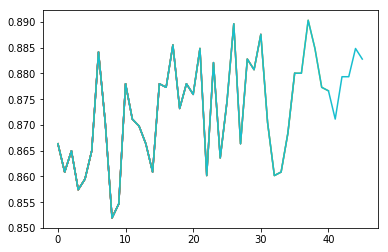

In [107]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

In [108]:
torch.save(model_ft, '/home/jasayles/code/Comp-Vis-Tour/model.pth')

In [109]:
model = torch.load('/home/jasayles/code/Comp-Vis-Tour/model.pth')

In [110]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [34]:
for inputs, labels in tqdm_notebook(dataloaders_dict2['test']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    print(labels)

tensor([12,  3,  5,  8, 21, 15,  8, 10], device='cuda:0')
tensor([ 9, 18,  1,  8, 21,  8, 10], device='cuda:0')


In [111]:
trainloader = dataloaders_dict2['test']
valloader = dataloaders_dict2['val']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


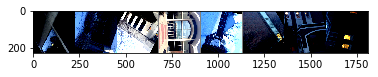

Decker   OLT   OLT  Kard  Libr  Hart  Hart  Libr


In [88]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
classes = ['Byrum', 'Decker','Dunn','Eflame',
           'FA','Flag','Hard','Hart','Helio',
           'Kard','Libr','Mart','Morr','Myer',
           'OLT','Passag','Peace','Prayer','Rear','Rice','Rock','Seal','Smith','Statue']
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


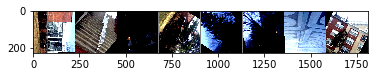

GroundTruth:    OLT  Libr Decker   OLT Decker Decker Prayer  Dunn


In [89]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [90]:
outputs = model(images.to(device))

In [91]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(8)))


Predicted:   Rice  Kard Decker   OLT Decker Decker Prayer  Dunn


In [112]:
correct = 0
total = 0
with torch.no_grad():
    for data in tqdm_notebook(valloader):
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 33 %


In [116]:
class_correct = list(0. for i in range(24))
class_total = list(0. for i in range(24))
with torch.no_grad():
    for data in tqdm_notebook(valloader):
        images, labels = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels.to(device)).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(24):
    if class_total[i] == 0:
        print('Accuracy of %5s : NULL' % (
        classes[i]))
    else:
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of Byrum : 100 %
Accuracy of Decker : 89 %
Accuracy of  Dunn : 53 %
Accuracy of Eflame : 100 %
Accuracy of    FA : 100 %
Accuracy of  Flag : 93 %
Accuracy of  Hard : 90 %
Accuracy of  Hart : 97 %
Accuracy of Helio : 100 %
Accuracy of  Kard : 94 %
Accuracy of  Libr : 87 %
Accuracy of  Mart : 81 %
Accuracy of  Morr : 92 %
Accuracy of  Myer : 83 %
Accuracy of   OLT : 87 %
Accuracy of Passag : 100 %
Accuracy of Peace : 90 %
Accuracy of Prayer : 100 %
Accuracy of  Rear : 75 %
Accuracy of  Rice : 86 %
Accuracy of  Rock : 60 %
Accuracy of  Seal : 100 %
Accuracy of Smith : 86 %
Accuracy of Statue : 100 %
